---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *In earlier labs, we have use the existing trigger mechanisms. What happens as you move to real-life? You'll likely want to use some of the triggering mechanisms discussed in the course. One such method is to actually trigger on serial data transfers.*

*The following lab is applicable only to ChipWhisperer-Lite (including both the -Arm, -Xmega, and verions included in SCAKIT-L1 and SCAKIT-L2). You can run this lab with the ChipWhisperer-Pro as well, but note you can use additional trigger modes (such as triggering on specific data), that will give you even more reliable triggers. The ChipWhisperer-Nano has a fixed trigger input, so cannot use the UART trigger options.*

**LEARNING OUTCOMES:**

* Exporing the Trigger Circuitry of the ChipWhisperer-Lite.
* Triggering on the UART data flow.


## About Simple-Serial Protocol

This lab will attack our protocol used in previous labs. Unlike previous labs (where we had a 'magic trigger'), we'll need to trigger on the UART communication.

To summarize, the general flow of the Simple-Serial Protocol is something like the following, where `→` means a transmission TO the target, and `←` means a response FROM the target.

    → p00112233445566778899AABBCCDDEEFF\n
    ← r0123456789ABCDEF1122334455667788\n
    ← z00\n

The encryption operation happens somewhere between sending `p112233445566778899AABBCCDDEEFF\n` and receiving `r0123456789ABCDEF11223344556677\n`. In this case, the above protocol sequence means: 

1. A `p`laintext of `0x00, 0x11, 0x22, 0x33, 0x44, 0x55, 0x66, 0x77, 0x88, 0x99, 0xAA, 0xBB, 0xCC, 0xDD, 0xEE, 0xFF` was sent to the target.
2. The target encrypted this plaintext.
3. The `r`esulting ciphertext is `0x01, 0x23, 0x45, 0x67, 0x89, 0xAB, 0xCD, 0xEF, 0x11, 0x22, 0x33, 0x44, 0x55, 0x66, 0x77, 0x88`.
4. The command was ACK'd with a `z` of `0x00`, where `0x00` in this case means command was successsful.

The encryption key was sent seperately in this example, but would have been sent with a `k` message similar to above.


### Talking to the Target

In lab 4.N, we use the built-in command `trace = cw.capture_trace(scope, target, text, key)` to capture a trace. This command assumes normal triggering based on an external IO line, and the communication protocol defined above.

If we attach an oscilloscope to the data lines, we can see the specific data being transferred, where we have the `TX` line, the normal trigger routed to `GPIO4`, the `RX` line, and the power measurement:

<img src="img/uart_triggers.png" alt="UART Trigger" width="750"/>

Notice something there? We could trigger on the IO lines to accomplish the same goal! While the `GPIO4` line shows exactly where the encryption is occuring, there is some very obvious falling edges around both the `TX` and `RX` lines before and after the encryption operation.

The timing isn't as perfect (some delay before the first falling edge of TX for example and the encryption), but it looks like it could work.

As we discussed in the course slides & video - there is a difference between triggering on the "TX" and "RX" sides. We expect that TX will have a little jitter, so if we can get RX working this will be even better.

## Connecting to the Hardware

As before - you'll need to connect to the hardware. To summarize the previous labs (in case you jumped ahead to this), this can be one of the following setups:

* ChipWhisperer-Lite XMEGA
* ChipWhisperer-Lite 32-bit (Arm)
* ChipWhisperer-Lite Capture with CW308 UFO Board using:
   * STM32F303 Target Board (same as `CWLITEARM`)
   * XMEGA Target Board (same as `CWLITEXMEGA`)
   * Any other target board (only the two above are 'tested').
* ChipWhisperer-Pro Capture with CW308 UFO Board using:
   * STM32F303 Target Board (same as `CWLITEARM`)
   * XMEGA Target Board (same as `CWLITEXMEGA`)
   * Any other target board (only the two above are 'tested').

You shouldn't need to change `SCOPETYPE` below, but you'll need to change `PLATFORM` to either `CWLITEARM` or `CWLITEXMEGA`:

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET='AVRCRYPTOLIB'

In [2]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2

Building for platform CWLITEXMEGA with CRYPTO_TARGET=AVRCRYPTOLIB
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWLITEXMEGA.hex
rm -f -- simpleserial-aes-CWLITEXMEGA.eep
rm -f -- simpleserial-aes-CWLITEXMEGA.cof
rm -f -- simpleserial-aes-CWLITEXMEGA.elf
rm -f -- simpleserial-aes-CWLITEXMEGA.map
rm -f -- simpleserial-aes-CWLITEXMEGA.sym
rm -f -- simpleserial-aes-CWLITEXMEGA.lss
rm -f -- objdir-CWLITEXMEGA/*.o
rm -f -- objdir-CWLITEXMEGA/*.lst
rm -f -- simpleserial-aes.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s aes-independant.s aes_enc.s aes_keyschedule.s aes_sbox.s aes128_enc.s
rm -f -- simpleserial-aes.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d aes-independant.d aes_enc.d aes_keyschedule.d aes_sbox.d aes128_enc.d
rm -f -- simpleserial-aes.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i aes-independant.i aes_enc.i aes_keyschedule.i aes_sbox.i aes128_enc.i
.
Welcome

In [3]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [4]:
cw.program_target(scope, prog, "../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 3761 bytes


In [5]:
scope.clock.adc_src = "clkgen_x4"

In [6]:
scope

cwlite Device
sn         = 50203220313038543030393131313039
fw_version = 
    major = 0
    minor = 51
    debug = 0
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state          = False
    basic_mode     = rising_edge
    timeout        = 2
    offset         = 0
    presamples     = 0
    samples        = 5000
    decimate       = 1
    trig_count     = 8261586
    fifo_fill_mode = normal
clock = 
    adc_src       = clkgen_x4
    adc_phase     = 0
    adc_freq      = 29538459
    adc_rate      = 29538459.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 26
    clkgen_freq   = 7384615.384615385
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1         = serial_rx
    tio2         = serial_tx
    tio3         = high_z
    tio4         = high_z
    pdid         = high_z
    pdic         = high_z
  

## Normal Capture Setup

Let's start with our existing capture. Confirm the following works before we start messing with things.

This makes an interactive plot, and then plots FOUR traces over-top of each other. This should look very similar to our previous power captures.

If you get in trouble later, run the block above that reconnects (you can skip programming).

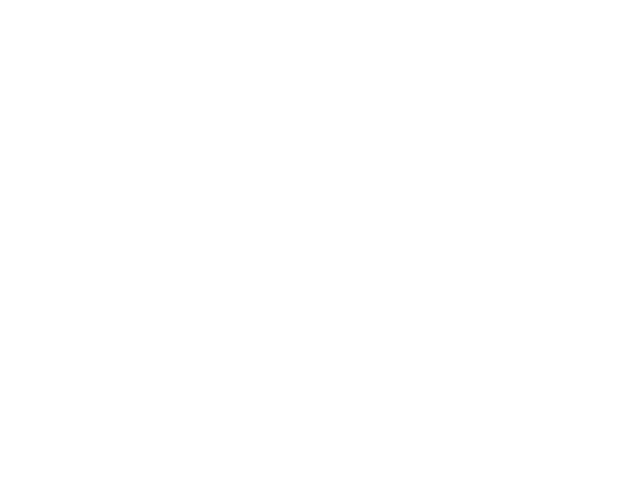

In [7]:
%matplotlib ipympl
import matplotlib.pylab as plt

fig = plt.figure()

In [8]:
from tqdm import trange
import numpy as np
import time

reset_target(scope)

fig.clf()
ktp = cw.ktp.Basic()
key, text = ktp.next()

target.simpleserial_write('k', key)
target.simpleserial_wait_ack()

N = 4
for i in trange(N, desc='Capturing traces'):

    scope.arm()
    target.simpleserial_write('p', text)    
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue

    response = target.simpleserial_read('r', 16)
        
    trace = scope.get_last_trace()
    
    #plt.clf()
    plt.plot(trace)
    fig.canvas.draw()
    time.sleep(0.5)

Capturing traces: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


## Changing Clocks & Observing Waveforms

Before we change triggers around, let's play with clocks and samples used. We need to remember a few specific features:

* Samples.
* Offsets.
* Pre-samples.
* Clock sources for ADC.

First - let's print a few relevant scope details:

In [9]:
print("* scope.adc settings:")
print(scope.adc)

print("* scope.clock settings:")
print(scope.clock)

print("ADC Clock frequency: " + str(scope.clock.adc_freq / 1E6) + " MS/s")

* scope.adc settings:
state          = False
basic_mode     = rising_edge
timeout        = 2
offset         = 0
presamples     = 0
samples        = 5000
decimate       = 1
trig_count     = 65604
fifo_fill_mode = normal

* scope.clock settings:
adc_src       = clkgen_x4
adc_phase     = 0
adc_freq      = 29538459
adc_rate      = 29538459.0
adc_locked    = True
freq_ctr      = 0
freq_ctr_src  = extclk
clkgen_src    = system
extclk_freq   = 10000000
clkgen_mul    = 2
clkgen_div    = 26
clkgen_freq   = 7384615.384615385
clkgen_locked = True

ADC Clock frequency: 29.538459 MS/s


#### Changing number of Samples

```python
    # Set number of samples to 24000 (max on CW-Lite)
    scope.adc.samples = 24000
```

#### Positive offset

We'll use `scope.adc.offset` to delay capture:

```python
    # Delay capture of ADC data a certain number of cycles
    scope.adc.offset = 20000
```
    
#### Negative offset

Finally, set `scope.adc.presamples` to some larger number`:

```python
    # Presamples gives us a negative offset effectively
    scope.adc.offset = 0
    scope.adc.presamples = 20000
```

Try each of the above in the following block - there is the plotting block right after it, so you can keep re-running the following 3 blocks in sequence to easily see your code changes:    

In [14]:
scope.adc.samples = 24000
scope.adc.offset = 0
scope.adc.presamples = 10000

We copied the above capture loop below for you so you can just run the following:

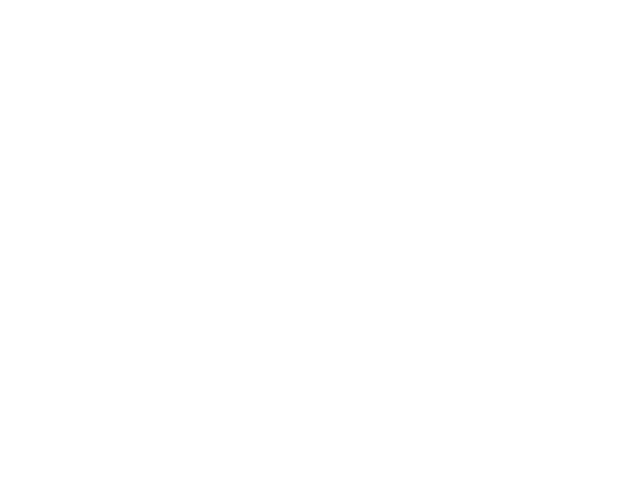

In [15]:
%matplotlib ipympl
import matplotlib.pylab as plt

fig = plt.figure()

In [16]:
from tqdm import trange
import numpy as np
import time

reset_target(scope)

fig.clf()
ktp = cw.ktp.Basic()
key, text = ktp.next()

target.simpleserial_write('k', key)
target.simpleserial_wait_ack()

N = 4
for i in trange(N, desc='Capturing traces'):
    
    scope.arm()
    target.simpleserial_write('p', text)    
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue

    response = target.simpleserial_read('r', 16)
        
    trace = scope.get_last_trace()
    
    #plt.clf()
    plt.plot(trace)
    fig.canvas.draw()

Capturing traces: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


#### Using `scope.clock.adc_src = "clkgen_x1"`

Using `clock.adc_src` we can run our ADC clock slower. The clock is still synchronously sampled, so we'll get very good power analysis results.

But by running the ADC clock at x1 the target, instead of x4, we basically get 4 times as many useful sample points. When we switch our trigger from the super-focused trigger we'll need some 'breathing room' to find the actual location the interesting stuff is running.

Run the following block, and then go up and run the capture test again. The first time you run the block, this should show the old ADC frequency of 29.4 MS/s. If you re-run it again later, the ADC will already be set to the slower frequency.

In [13]:
import time

#Reset settings from above
scope.adc.samples = 24000
scope.adc.offset = 0
scope.adc.presamples = 0

print("Initial ADC clock:")
print(" ADC Clock frequency: " + str(scope.clock.adc_freq / 1E6) + " MS/s")

scope.clock.adc_src = "clkgen_x1"

#Give time for frequency counter to update, as clock.adc_freq is a frequency counter
time.sleep(0.25)

print("New ADC clock:")
print("  ADC Clock frequency: " + str(scope.clock.adc_freq / 1E6) + " MS/s")

Initial ADC clock:
 ADC Clock frequency: 29.538459 MS/s
New ADC clock:
  ADC Clock frequency: 7.384609 MS/s


## Changing Trigger Item

Final thing to do - change the trigger setting! As mentioned before, we're going to experiment with `tio1` and `tio2` pins.

What do those pins actually do? Run the following to see the configuration for your board:

In [17]:
print("tio1 function: " + scope.io.tio1)
print("tio2 function: " + scope.io.tio2)

tio1 function: serial_rx
tio2 function: serial_tx


In my case, `tio1` is `serial_rx`, and `tio2` is `serial_tx`. This could change depending on the target board you selected.

This means that `tio1` would be used to trigger on data received FROM the target, and `tio2` for data sent TO the target.

We can see the current settings of the trigger module by running the following block:

In [18]:
print("scope.trigger:\n" + str(scope.trigger))
print("scope.adc.basic_mode: " + scope.adc.basic_mode)

scope.trigger:
triggers = tio4
module   = basic

scope.adc.basic_mode: rising_edge


### Changing Capture Loop

If you check out the capture loop from above, you'll see the following code block. This code block will send data to the target, wait for the trigger, and then finish reading.

```python
    scope.arm()
    target.simpleserial_write('p', text)

    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue

    response = target.simpleserial_read('r', 16)
```

We need to change this around a little bit. Instead, we need to call `scope.capture()` *after* the serial data exchange happened. We're doing this because `scope.arm()` still happens before the serial transmission, so the hardware is still capturing data.

The problem is that `scope.capture()` blocks - the capture hardware is always ready to capture as soon as `scope.arm()` is called. But `scope.capture()` says "now wait until you see the trigger".

In this case, we now want to do that blocking wait after the full transmission protocol happens. See the following, where `scope.capture()` is now after the `target.simpleserial_read()`:

```python
    scope.arm()
    target.simpleserial_write('p', text)
    
    response = target.simpleserial_read('r', 16)

    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
```

The following series of plotting and capture should work with the existing trigger, right before we set a new trigger logic. Because we're going to be coming back to this - we're making this into it's own little capture block.

### New Capture Loop
---

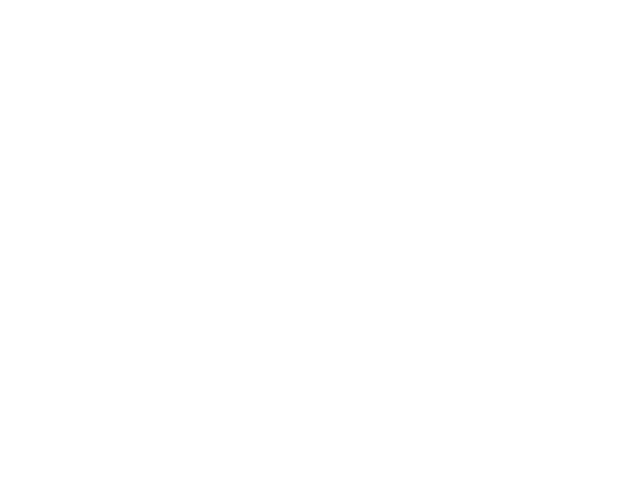

In [24]:
%matplotlib ipympl
import matplotlib.pylab as plt

fig = plt.figure()

In [27]:
# Insert your code here to perform changes in captures
# for example - change the number of samples, change the offset, etc

# A simple example - just changing the number of samples
scope.adc.samples = 24000
scope.adc.offset = 60000
scope.adc.presamples = 0

In [32]:
from tqdm import trange
import numpy as np
import time

reset_target(scope)

fig.clf()
ktp = cw.ktp.Basic()
key, text = ktp.next()

target.simpleserial_write('k', key)
target.simpleserial_wait_ack()

N = 4
for i in trange(N, desc='Capturing traces'):
    
    scope.arm()
    target.simpleserial_write('p', text)

    response = target.simpleserial_read('r', 16)

    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue

    trace = scope.get_last_trace()
    
    #plt.clf()
    plt.plot(trace)
    fig.canvas.draw()

Capturing traces: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


---

### Trigger on Transmit Pin

Let's configure this for `tx` first. In this example, `tio2` is the transmit pin. Run the following block to set the trigger for use "tio2":

In [22]:
print(scope.adc.basic_mode)
print(scope.trigger)

rising_edge
triggers = tio4
module   = basic



In [23]:
scope.adc.basic_mode = "falling_edge"
scope.trigger.triggers = "tio2"

# raise NotImplementedError("Comment this line out - then run this block & then re-run new capture loop just above!")

Now let's change `scope.adc.offset` - if we are capturing every ~24000 samples, you should be able to iterate through in blocks of around 20000 samples. So you could set this to `20000`, `40000`, `60000`, etc. Here's it's set to 0.

Re-run the capture block above with new settings of `scope.adc.offset` - suggested to copy the follow setting code above, so you don't need to forget about re-running this block!

In [ ]:
# scope.adc.offset = 0

# scope.adc.offset = {20000, 40000, 60000, 80000}
# raise NotImplementedError("Copy the scope.adc.offset line to the `New Capture Loop` section.")

Most likely - you'll see some not very interesting looking power traces. These power traces have been captured during the serial transmission phase of data, not the AES phase. You'll need to move around (using the `offset`) to find data of interest. Here's what the not interesting figure looks like:

<img src="img/4traces_aes_poortrigger.png" alt="Poor Trigger" width="450"/>

Eventually you should see some interesting looking data! The `offset` in the following was set to `60000`, but yours may be different. If you zoom into the power trace, you'll see some jitter on the trace, as things are not perfectly aligned:

<img src="img/4traces_aes_clkx1_offset60000.png" alt="Using Pre-Sample, Zoomed In" width="450"/>

We can re-align the traces using techniques covered in the SCA201 course, to shift the power trace around such they all line up, letting us use this "jittery" trace in the attack.

Or, we can use the receive pin technique discussed next.

### Trigger on Receive Pin

Let's configure this for `rx` first. In this example, `tio1` is the receive pin.

We'll set the offset back to 0, and now use "tio1":

In [29]:
print(scope.adc.basic_mode)
print(scope.trigger)

falling_edge
triggers = tio2
module   = basic



In [30]:
scope.adc.basic_mode = "falling_edge"
scope.trigger.triggers = "tio1"
scope.adc.offset = 0

# raise NotImplementedError("Run this block & then re-run new capture loop just above!")

Run the block above - you'll see a lack of interesting activity! So use a feature called 'presample' which allows us to sample "before" the trigger. The maximum number of pre-samples before is what we set `samples` to. So in this case we had up to `24000` samples, so we'll use `20000` pre-samples.

Run this block - the re-run the capture block again.

In [31]:
scope.adc.presamples = 20000

# raise NotImplementedError("Run this block & then re-run new capture loop just above!")

Hopefully, when you run the capture you will now have some more interesting looking data. For example, in my run there is an obvious AES run right in the middle of this:

<img src="img/4traces_aes_clkx1_presample5000.png" alt="Using Pre-Sample with CLKGEN=x1" width="450"/>

This was taken with a `presample` of `20000`, in this case meaning the trigger happened right at 5000, right around when the interesting looking power trace happens. If we zoom in on it, you should hopefully see a nice reliable power trace:

<img src="img/4traces_aes_clkx1_presample5000_zoom.png" alt="Using Pre-Sample, Zoomed In" width="450"/>

As discussed in the training video - this makes sense, because the receive trigger is being sent under control of the target device. But even with jitter in the power trace, we can easily recover it using some of the synchronization techniques discussed in course SCA201.


In [33]:
target.dis()
scope.dis()

True

### Next Steps

This notebook only did the capture, it didn't run the actual attack! You can use the captured data to perform an actual attack of course as well.

All the capture loops here don't have the data recording logic, so you'll need to go back and add that in. Don't forget how we had to change the location of `scope.capture()` when we modified the block.

You can also look at using external trigger logic. The ChipWhisperer-Pro (CW1200) has more advanced trigger logic, including hardware trigger on specific data values of UART or SPI, along with analog power trace triggers. Other NewAE tools such as the PhyWhisperer-USB can be used to trigger on protocols such as USB.

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>